首先每个电脑或者设备都记录了自己的DNS服务地址, 当自己本机缓存(hosts file)找不到domain对应的ip的时候, 就会向自己的DNS Servers(NameServers)求救, 

Linux查看自己的NameServers

```shell
cat /etc/resolv.conf
# This file is automatically generated.
#
search home
nameserver 192.168.2.1
nameserver 142.166.166.166
```

查看host file的位置`/etc/hosts`, 如果你这个文件里的把`www.google.com`的值改为`127.0.0.1`(没有可以添加),之后`ping`和浏览器都无法访问谷歌了. 

平时有的学校机房, 你只能用谷歌搜索东西, 但就是进不去其他网站, 只能进学校的官网和几个学校常用的网站, 这就很明显学校把每个机器的DNS服务器修改成了错误的, 这种概率不大, 因为我们还可以改回来, 更保险的是学校直接设置路由器的DNS, 电脑上显示DNS然后后面跟了一个ip列表, 其实这里的DNS默认的就是DNS服务器(又叫NameServers). 

那么路由器的DNS和我们电脑的DNS有什么关系呢, 其实你看上面我电脑的输出就能看出, 两个nameservers, 其中一个是`192.168`很明显这是个局域网ip, 这个就是我家路由器的ip地址了. 为啥子哩, 谁设置的呢? 答案是DHCP. 还有个东西叫默认网关default gateway, 它的值也是路由器ip, 即所有非局域网的包都会发到默认网关, 由默认网关来转发到另一个网络, 但是这么一看怎么觉得默认网关和刚刚的值为路由器ip的nameserver有点重复呢? 感兴趣可以自己查查原因,我也不晓得

路由器采用了一种 DHCP 的技术, 默认情况下，在为路由器设置好 DNS 后，路由器会将连接到该网络上的设备的 DNS 服务器，设置为自己的 IP 地址。网络上设备的 DNS 请求，统一发送至路由器 IP 地址，此时路由器扮演各设备的 DNS 服务器。然后，路由器转发 DNS 请求，到实际的 DNS 服务器。实际的 DNS 服务器解析域名 IP，返回给路由器。最后，路由器再把 IP 返回给终端设备。

----

有点绕，用笔者连接的小米路由器举个例子：

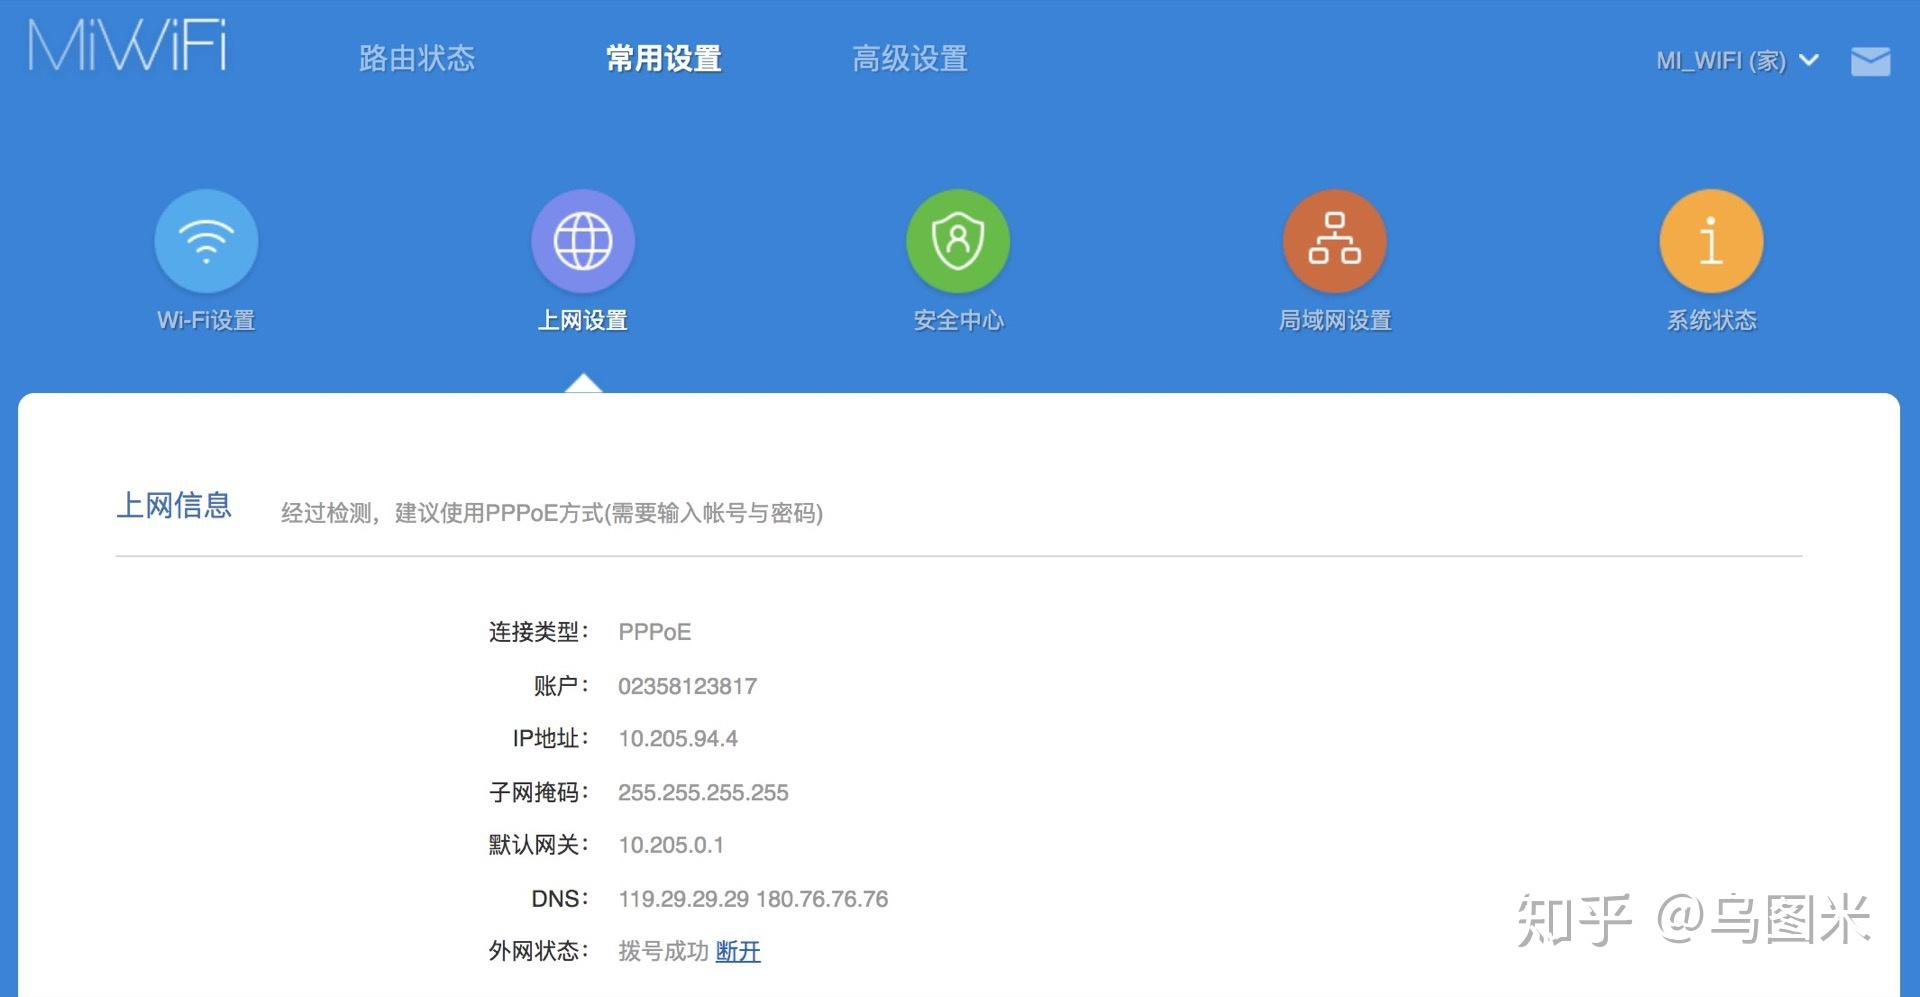

- 路由器设置 DNS 服务器为223.5.5.5 / 180.76.76.76，这是实际的 DNS 服务器。
- 路由器开启 DHCP 服务，自身的局域网 IP 地址为192.168.31.1。
- MBP 连接到这台路由器的无线网络，按照上述路径查看当前网络的 DNS 服务器，显示为192.168.31.1，即路由器的 IP 地址。

在这种情况下，可能无法直接从设备的网络设置里面查看到真实的 DNS 服务器，因为路由器在其中扮演着转发 DNS 请求的角色。目前，许多路由器都采用了这一方式，但也有支持在 DHCP 服务开启时，直接设置设备连接时使用的 DNS 的功能，比如 TP-LINK 系列。

参考:

- [DNS 与路由器设置马克 - 知乎](https://zhuanlan.zhihu.com/p/105942315)

-----

## 1. DNS Records
----

> A **DNS record** is a database record used to map a URL to an IP address. **DNS records** are stored in **DNS servers** and work to help users connect their websites to the outside world. 

- A（Address）记录是用来指定主机名（或域名）对应的IP地址记录。简单来讲，A记录就是指定域名对应的IP地址。

- NS Record存储的是域名的Name Server的ip地址

上面说了DNS records的分类, 所以知道了设置`A` record就是把我们VPS服务器的IP地址绑定到我们的域名, 然后根据下图我们也可以看出即使没有将域名绑定(自己设置域名的Arecords), 但域名默认也是有`A` records的, 所以也就是说默认域名也有ip地址, 其实说白了 给一个域名增加个 `A` record就是我们把域名绑定vps服务器的过程, 所以说域名有没有ip地址其实就是问ip有没有`A` record, 下面我会截图示意怎么给一个域名添加`A`record, 

使用`dig shaowenzhu.top`查看域名的DNS解析过程

```shell
dig shaowenzhu.top

# 其中有段输出为下, 其实就是我域名的A record, 所谓的ip地址信息就在A record里面, 啥是record? 就是url和ip的一个map表
;; ANSWER SECTION:
shaowenzhu.top.		3603	IN	A	91.195.240.123
```

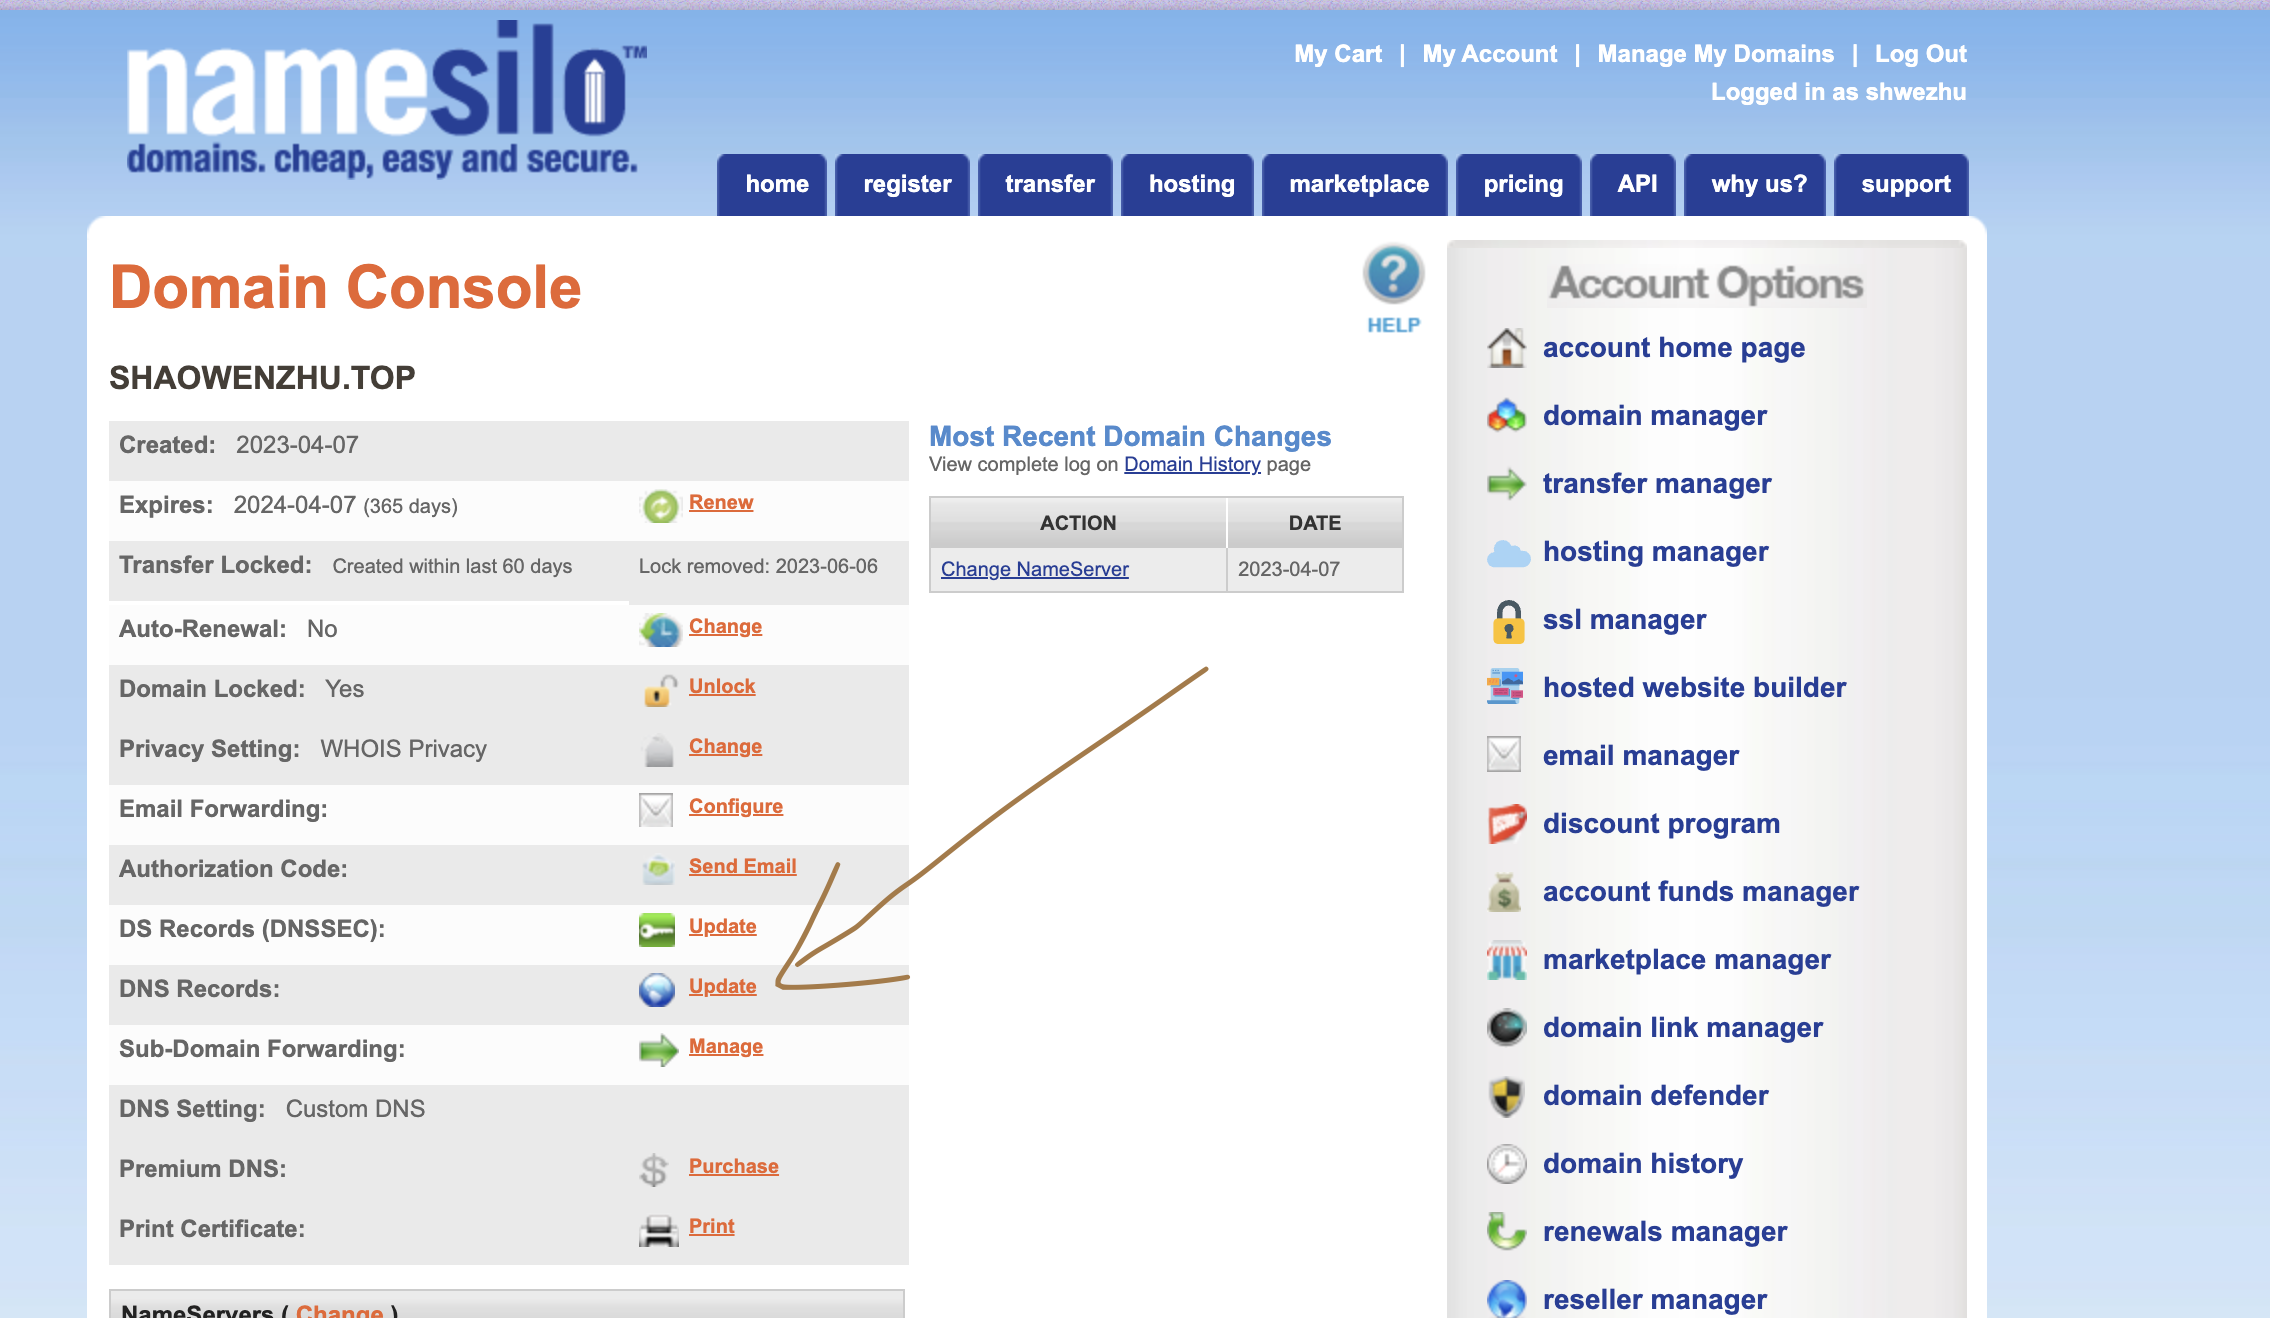

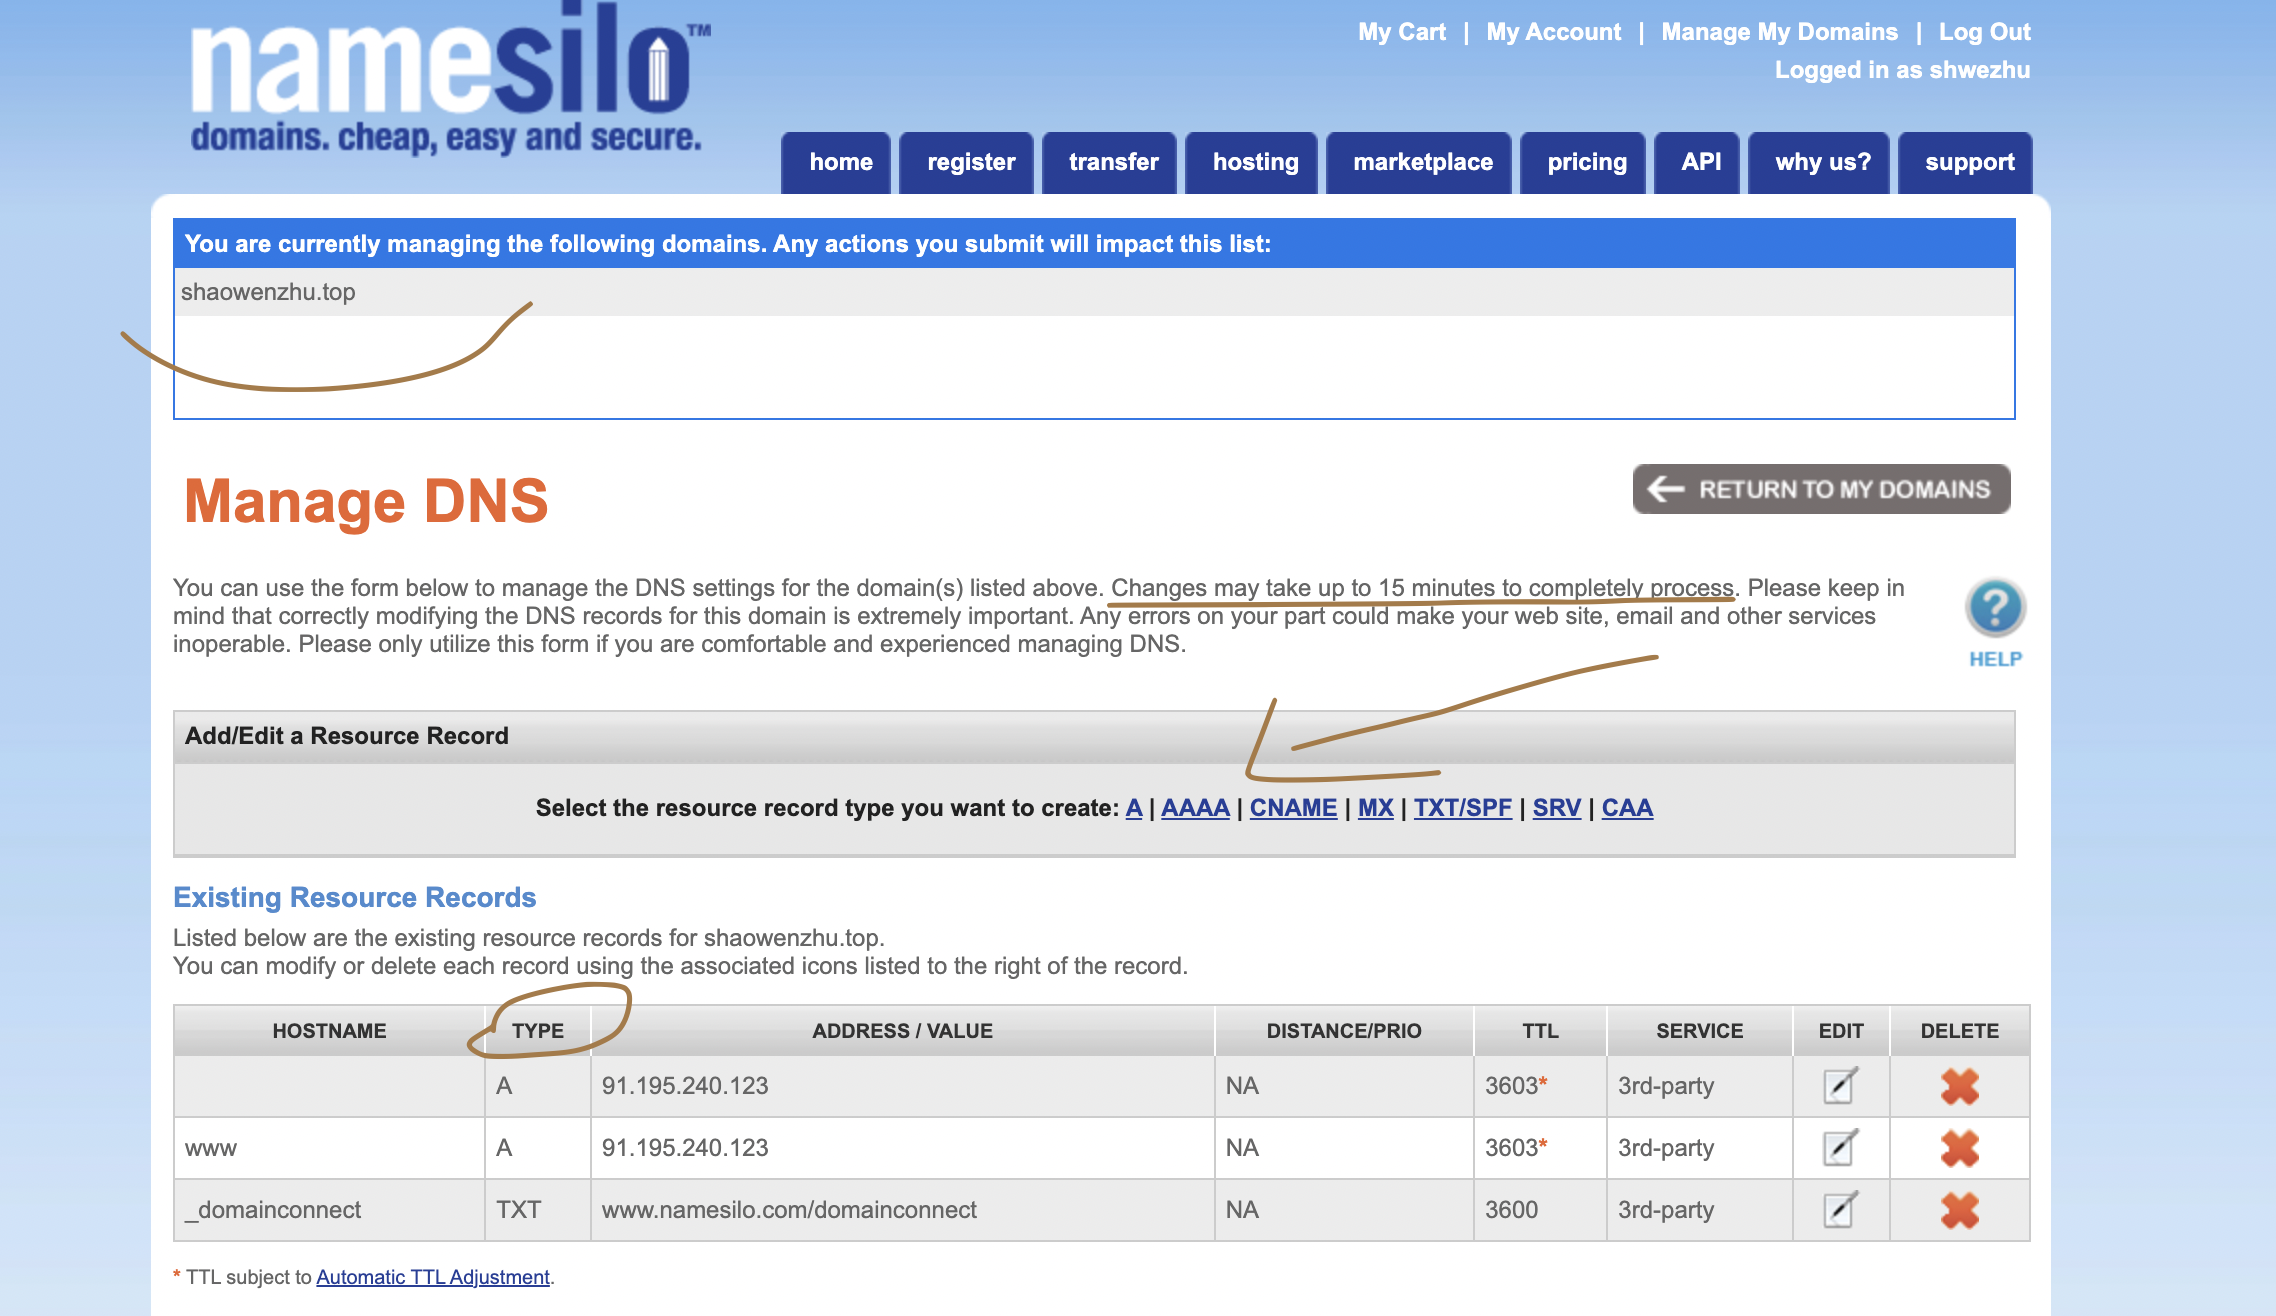

上图可以看到截图中的`A` record中的ip与上面指令`dig`查询到的一样. 上面的 DNS record有个属性是TTL, 写着3603, 这是什么意思呢?

> DNS TTL (time to live) is a setting that tells the DNS resolver how long to cache a query before requesting a new one. The information gathered is then stored in the cache of the recursive or local resolver for the TTL before it reaches back out to collect new, updated details.

那它的值一般设置多少合适呢?(我们给我们的域名增加`A` record的时候)

- 300 seconds = 5 minutes = “Very Short” – Websites within this timeframe use a low TTL focus to make fast changes but still can utilize some level of caching to help reduce resource consumption.

- 3600 seconds = 1 hour = “Short” – Websites within this timeframe use a low TTL focus to make fast changes but still can utilize some level of caching to help reduce resource consumption.

- 86400 seconds = 24 hours = “Long” – The opposite applies for websites using a 24 hour TTL as the focus shifts more towards a daily cache utilization.

## 2. `dig` Command &  Understand NS Records
-----

First, let's look at a simple domain name to IP address mapping:

```shell
dig web01.bugsplat.info
```

The `dig` command is a veritable Swiss Army knife for querying DNS servers and we'll be using it quite a bit. Here's the first part of the response:

```
; <<>> DiG 9.10.6 <<>> web01.bugsplat.info
;; global options: +cmd
;; Got answer:
;; ->>HEADER<<- opcode: QUERY, status: NOERROR, id: 7841
;; flags: qr rd ra; QUERY: 1, ANSWER: 1, AUTHORITY: 4, ADDITIONAL: 1
```

There's only one interesting thing in here. We asked for one record and got exactly one respose. Here's the question we asked:


```
;; QUESTION SECTION:
;web01.bugsplat.info.       IN  A
```

dig defaults to asking for `A` records. `A` stands for address and is one of the basic fundamental types of records in the DNS. An `A` record holds exactly one IPv4 address. There's an equivalent record for IPv6 addresses named `AAAA`. Next, let's look at the answer our DNS server gave us:

```
;; ANSWER SECTION:
web01.bugsplat.info.	300	IN	A	192.241.250.244
```

This says the host `web01.bugsplat.info.` has exactly one `A` address: `192.241.250.244`. The `300` is called the TTL value, or time to live. The `IN` component stands for Internet and is meant to disambiguate between the various types of networks that the DNS historically was responsible for. 

The rest of the response tells you things about the response itself:

```
;; Query time: 47 msec
;; SERVER: 192.168.2.1#53(192.168.2.1)
;; WHEN: Sat Apr 08 09:34:42 ADT 2023
;; MSG SIZE  rcvd: 203
```

Specifically, it tells you how long it took for your server to respond, what that server's IP address is (`192.168.2.1`), what port dig asked (`53`, the default DNS port), when the query completed, and how many bytes the response contained.

As you can see, there's an awful lot going on in a single DNS query. Every time you open a web page your browser makes literally dozens of these queries to resolve the web host, all of the hosts where external resources like images and scripts are located, etc. Every single resource involves at least one DNS query, which would involve an awful lot of traffic if DNS wasn't designed to be heavily cached.

What you probably can't see, however, is that the DNS server at `192.168.2.1` contacted a whole chain of other servers in order to answer that simple question of what address does `web01.bugsplat.info` map to. Let's run a `trace` to see all of the servers that dig would have to contact if they weren't already cached:

```
dig +trace web01.bugsplat.info

; <<>> DiG 9.7.6-P1 <<>> +trace web01.bugsplat.info
;; global options: +cmd
.           137375  IN  NS  l.root-servers.net.
.           137375  IN  NS  m.root-servers.net.
.           137375  IN  NS  a.root-servers.net.
.           137375  IN  NS  b.root-servers.net.
.           137375  IN  NS  c.root-servers.net.
.           137375  IN  NS  d.root-servers.net.
.           137375  IN  NS  e.root-servers.net.
.           137375  IN  NS  f.root-servers.net.
.           137375  IN  NS  g.root-servers.net.
.           137375  IN  NS  h.root-servers.net.
.           137375  IN  NS  i.root-servers.net.
.           137375  IN  NS  j.root-servers.net.
.           137375  IN  NS  k.root-servers.net.
;; Received 512 bytes from 192.168.1.1#53(192.168.1.1) in 189 ms

info.           172800  IN  NS  c0.info.afilias-nst.info.
info.           172800  IN  NS  a2.info.afilias-nst.info.
info.           172800  IN  NS  d0.info.afilias-nst.org.
info.           172800  IN  NS  b2.info.afilias-nst.org.
info.           172800  IN  NS  b0.info.afilias-nst.org.
info.           172800  IN  NS  a0.info.afilias-nst.info.
;; Received 443 bytes from 192.5.5.241#53(192.5.5.241) in 1224 ms

bugsplat.info.      86400   IN  NS  ns-1356.awsdns-41.org.
bugsplat.info.      86400   IN  NS  ns-212.awsdns-26.com.
bugsplat.info.      86400   IN  NS  ns-1580.awsdns-05.co.uk.
bugsplat.info.      86400   IN  NS  ns-911.awsdns-49.net.
;; Received 180 bytes from 199.254.48.1#53(199.254.48.1) in 239 ms

web01.bugsplat.info.    300 IN  A   192.241.250.244
bugsplat.info.      172800  IN  NS  ns-1356.awsdns-41.org.
bugsplat.info.      172800  IN  NS  ns-1580.awsdns-05.co.uk.
bugsplat.info.      172800  IN  NS  ns-212.awsdns-26.com.
bugsplat.info.      172800  IN  NS  ns-911.awsdns-49.net.
;; Received 196 bytes from 205.251.195.143#53(205.251.195.143) in 15 ms
```


## 3. 域名的分级
----

DNS服务器怎么会知道每个域名的IP地址呢？答案是分级查询, 仔细看前面的例子，每个域名的尾部都多了一个点。

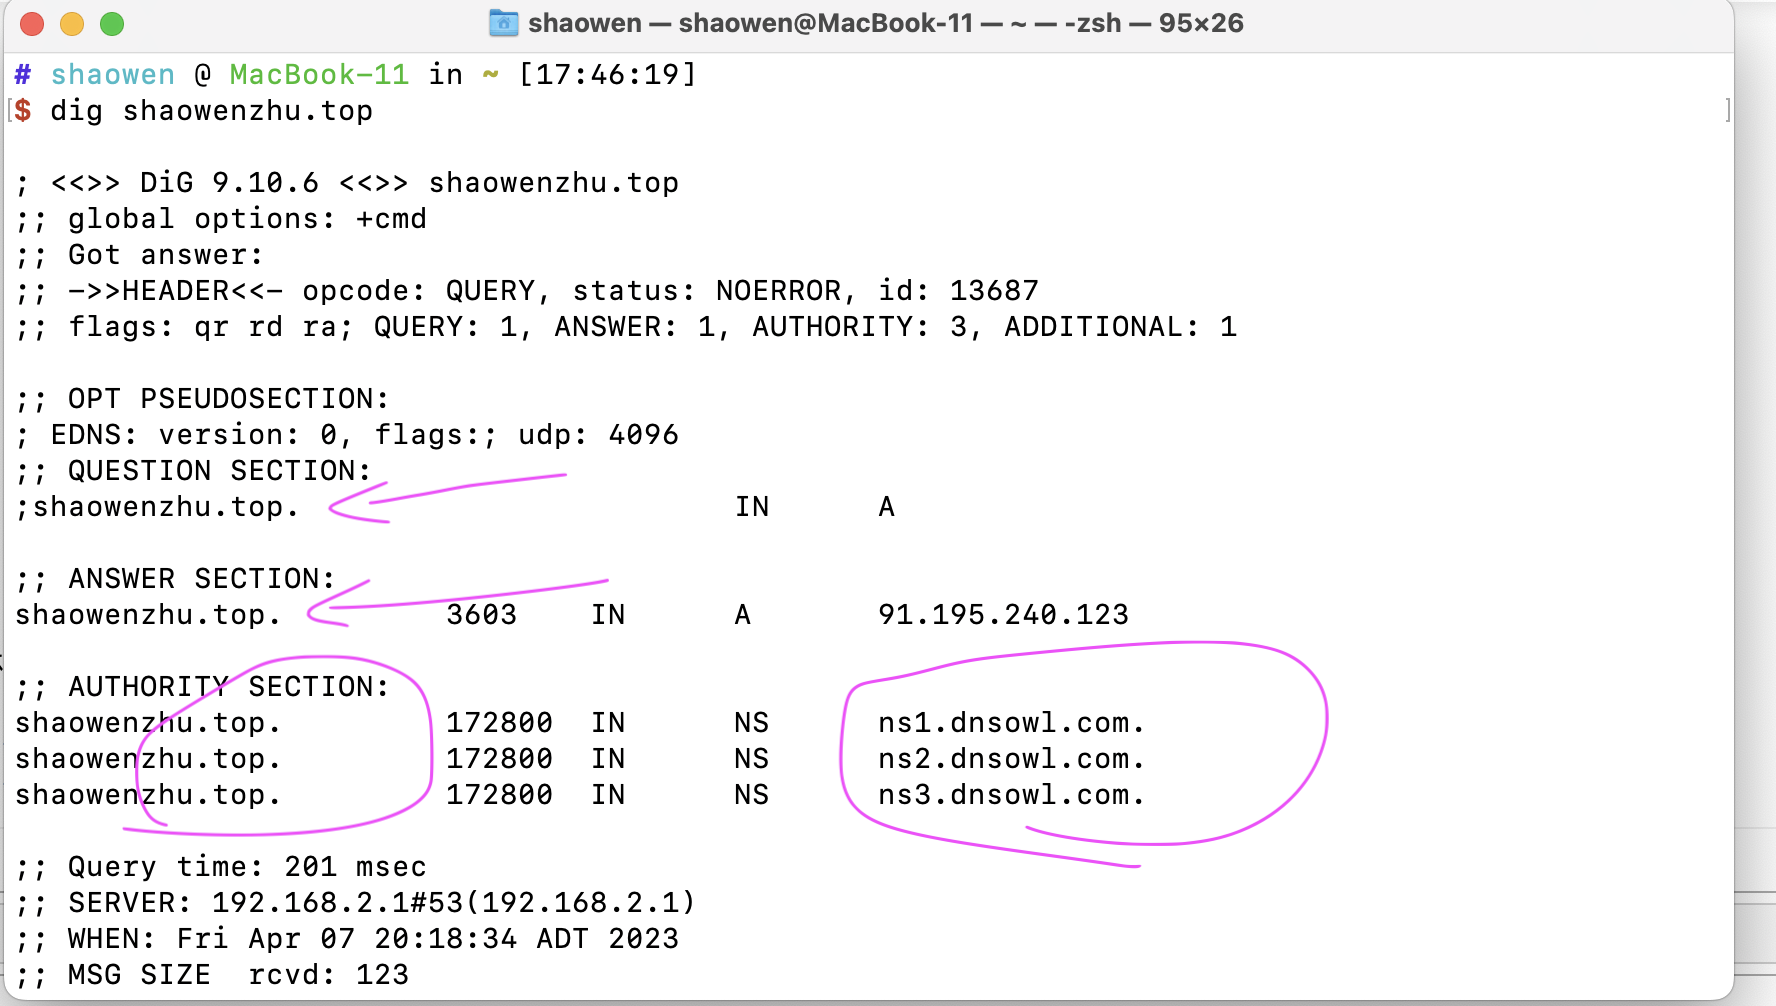

这不是疏忽，而是所有域名的尾部，实际上都有一个根域名。举例来说，`www.example.com`真正的域名是`www.example.com.root`简写为`www.example.com.` 因为根域名`.root`对于所有域名都是一样的，所以平时是省略的。

根域名(`.root`)的下一级，叫做"顶级域名"（top-level domain，缩写为TLD），比如`.com`, `.net`；

再下一级叫做"次级域名"（second-level domain，缩写为SLD），比如`www.example.com`里面的`.example`，这一级域名是用户可以注册的；再下一级是主机名（host），比如`www.example.com`里面的`www`，又称为"三级域名"，这是用户在自己的域里面为服务器分配的名称，是用户可以任意分配的。那具体怎么分配呢? 就是在域名管理页面, 有添加DNS Records选项, 比如你打算添加个A类记录, 这时候要求你填HOSTNAME和IP地址, 这时候HOSTNAME你可以填`www`, `@`, `blog`等等, 然后IP就是你的服务器的IP地址, 

总结一下，域名的层级结构如下:

```
host.sld.tld.root
```